In [1]:
import numpy as np
import folium
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import point
from sklearn.cluster import KMeans
import fiona
import pyproj  # 좌표계 정의/변환용 라이브러리
from fiona.crs import from_epsg
import seaborn as sns

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### (2) 군집화 

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [3]:
bus=pd.read_csv('category3전처리.csv')
bus

,정류장ID,정류장명,산부인과의료진,취약거주인구,노령정원합,영유아정원합,lon,lat
0,201000313,권선구청,0.0,0.0,0.0,181.0,126.970983,37.256983
1,201000345,남수원초등학교,2.0,3897.0,52.0,1201.0,127.016000,37.251091
2,201000379,신미주아파트,0.0,5048.0,104.0,4227.0,126.953845,37.268806
3,201000055,농수산물시장,0.0,3237.0,58.0,2053.0,127.029815,37.256755
4,201000268,곡반중학교,68.0,3317.0,0.0,1773.0,127.034254,37.246081
...,...,...,...,...,...,...,...,...
923,202000249,화서오거리,2.0,4791.0,72.0,1523.0,126.999697,37.278865
924,202000241,숙지공원.화서동굿모닝힐.화서다산도서관,5.0,4323.0,132.0,1802.0,126.995823,37.284316
925,202000246,엘지아파트.금강아파트,0.0,4837.0,99.0,2416.0,126.981714,37.287994
926,202000239,꽃뫼신동아아파트,5.0,2490.0,21.0,977.0,126.986076,37.286663


In [4]:
#표준화
MM = MinMaxScaler()
bus_target=bus[['산부인과의료진','취약거주인구','노령정원합','영유아정원합']]
bus_MM=pd.DataFrame(MM.fit_transform(bus_target))
bus_MM.columns=['freg','weak_pop','old_infra','young_infra']


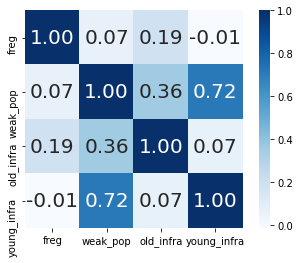

In [5]:
#변수별 상관계수
corr = bus_MM.corr(method='pearson')
df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 20}, fmt = '.2f', square = True, cmap = 'Blues')

In [6]:
temp=bus_MM[['freg','old_infra','young_infra']]

temp2=pd.DataFrame({'infra':temp.apply(sum,1)})
temp2['pop']=bus_MM['weak_pop']
temp2.insert(0,'정류장ID',bus['정류장ID'])
temp2

,정류장ID,infra,pop
0,201000313,0.038626,0.000000
1,201000345,0.355810,0.564210
2,201000379,1.079221,0.730853
3,201000055,0.536921,0.468655
4,201000268,0.749946,0.480237
...,...,...,...
923,202000249,0.458597,0.693644
924,202000241,0.636744,0.625887
925,202000246,0.684232,0.700304
926,202000239,0.271591,0.360504


In [7]:
temp2['tot']=temp2['infra']+temp2['pop']

/opt/app-root/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


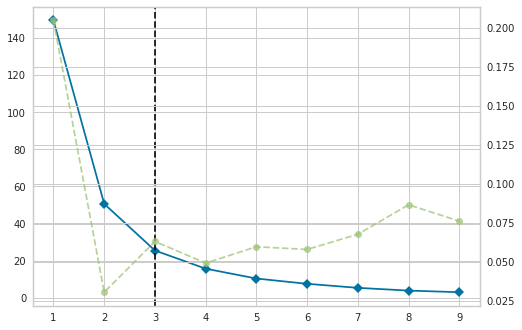

In [8]:
bus_MM_arr1 = temp2[['infra','pop']].values
bus_MM_arr2 = temp2[['tot']].values

from yellowbrick.cluster import KElbowVisualizer
 
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(bus_MM_arr1.reshape(-1,1))

### yellow-elbow로는 3개가 적절하다고 나왔는데 점수 구분을 위해 4개의 군집 선택

In [9]:
kmeans = KMeans(n_clusters =4,random_state=1).fit(bus_MM_arr1)
temp2['cluster1'] = kmeans.labels_
temp2.groupby('cluster1').median()

,정류장ID,infra,pop,tot
cluster1,,,,
0,202000032.0,0.379410,0.394383,0.789822
1,201000400.5,0.607959,0.629000,1.221115
2,201000590.0,0.121971,0.173158,0.311701
3,201000209.5,0.969614,0.671493,1.658166


In [10]:
kmeans = KMeans(n_clusters =4,random_state=1).fit(bus_MM_arr2)
temp2['cluster2'] = kmeans.labels_
temp2.groupby('cluster2').median()

,정류장ID,infra,pop,tot,cluster1
cluster2,,,,,
0,202000024.5,0.379719,0.401042,0.795060,0
1,201000342.0,0.624475,0.592298,1.225111,1
2,201000590.5,0.124093,0.175402,0.317522,2
3,201000382.0,0.977179,0.737947,1.684799,3


### 군집별 점수부여
* 3번군집 : 1점
* 1번군집 : 0.75점
* 2번군집 : 0.25점
* 0번군집 : 0.5점

In [11]:
temp2['score']=np.where(temp2['cluster2']==2,0.25,np.where(temp2['cluster2']==0,0.5,np.where(temp2['cluster2']==1,0.75,1)))

In [12]:
temp2.sort_values('tot',ascending=False).groupby('cluster2').head(10)

,정류장ID,infra,pop,tot,cluster1,cluster2,score
645,200000066,1.526941,0.682641,2.209582,3,3,1.00
441,200000063,1.526941,0.674533,2.201474,3,3,1.00
271,200000037,1.522246,0.617924,2.140170,3,3,1.00
111,200000093,1.488193,0.636021,2.124214,3,3,1.00
227,201000176,1.177172,0.896627,2.073799,3,3,1.00
359,203000038,1.627481,0.445056,2.072537,3,3,1.00
71,201000053,1.350348,0.715072,2.065420,3,3,1.00
600,203000089,1.133607,0.918633,2.052241,3,3,1.00
467,203000160,1.048100,0.995222,2.043322,3,3,1.00
478,203000159,1.059797,0.978138,2.037935,3,3,1.00


## 2차 점수산출
##### category3_score = score 에서 군집별로 나눈점수  -  (2.5 / 군집내 정류장수)


In [13]:
for j in range(4):
    adjust_score=np.array([(0.25*(1/temp2.groupby('cluster2').size()))[j]*(i) for i in range(len(temp2[temp2['cluster2']==j]))])
    temp2[temp2['cluster2']==j].sort_values(by='tot',ascending=False)['score']=temp2[temp2['cluster2']==j].sort_values(by='tot',ascending=False)['score']-adjust_score
    score_adj=temp2[temp2['cluster2']==j].sort_values(by='tot',ascending=False)['score']-adjust_score
    temp2.iloc[score_adj.index,6]=score_adj

In [14]:
temp2.rename(columns={'score':'category3_score'},inplace=True)

In [15]:
category3=temp2[['정류장ID','category3_score']]
category3.insert(1,'lon',bus.lon)
category3.insert(1,'lat',bus.lat)
category3

,정류장ID,lat,lon,category3_score
0,201000313,37.256983,126.970983,0.015873
1,201000345,37.251091,127.016000,0.440299
2,201000379,37.268806,126.953845,0.934564
3,201000055,37.256755,127.029815,0.496269
4,201000268,37.246081,127.034254,0.630309
...,...,...,...,...
923,202000249,37.278865,126.999697,0.584942
924,202000241,37.284316,126.995823,0.642857
925,202000246,37.287994,126.981714,0.704633
926,202000239,37.286663,126.986076,0.294776


In [16]:
category3.to_csv('category3.csv',index=False)

### 시각화

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'pop')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


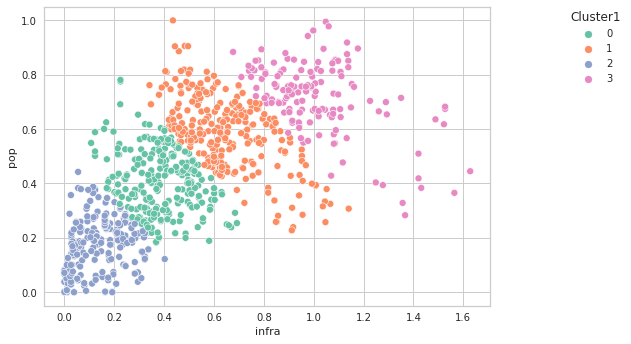

In [18]:
sns.set_palette('Set2')


sns.scatterplot(x='infra',y='pop',hue='cluster2',data=temp2,palette='Set2')
plt.legend(title='Cluster1',bbox_to_anchor=(1.3,1),borderaxespad=0)
plt.xlabel('infra')
plt.ylabel('pop')